"""
PCA paso a paso sobre el dataset **Palmer Penguins**
=========================================================================


Secuencia ->

1.   Instalar librerías
2.   Cargar librerías y datos
3.   Normalizar variables numéricas
4.   Aplicar PCA (todas las componentes)
5.   Mostrar cargas (loadings) y coordenadas (scores)
6.   Scree plot + PVE acumulado
7.   Scatter PC1 vs PC2 diferenciando especie y sexo


*   Autor   : Guillermo Pinto
*   Fecha    : Julio 2025




Licencia : Gorman, K., et al. Palmer Station LTER. Palmer Archipelago (Antarctica) penguin data. CC‑0.
"""

In [18]:
# %% ------------------------------------------------------------------
# 1) Importar librerías y cargar el dataset
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Intentamos usar la librería *palmerpenguins* (oficial).
# Si no está instalada, hacemos fallback al CSV que aloja Seaborn.
try:
    from palmerpenguins import load_penguins  # => pip install palmerpenguins
    penguins = load_penguins()
except ModuleNotFoundError:
    import seaborn as sns                     # seaborn suele estar en Colab
    penguins = sns.load_dataset("penguins")





In [19]:

# Eliminamos filas con valores NA para evitar errores de PCA.
penguins = penguins.dropna()

In [20]:
# %% ------------------------------------------------------------------
# 1.b) Revisamos las primeras 6 filas
# ---------------------------------------------------------------------
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [21]:
# %% ------------------------------------------------------------------
# 1c) Codificar especie y sexo a números ⟶ nuevas columnas
# ---------------------------------------------------------------------
# PCA solo acepta valores numéricos. Para mantener **6 variables** agregamos:
#   • species_num : 0 = Adelie, 1 = Chinstrap, 2 = Gentoo
#   • sex_num     : 0 = Female,  1 = Male
# Usamos LabelEncoder porque genera *una sola* columna por variable
# y así no aumentamos dimensiones con one‑hot.

# --- Codificar species ---
le_species = LabelEncoder()
penguins["species_num"] = le_species.fit_transform(penguins["species"])
# --- Codificar sex (con cuidado: algunos registros pueden usar minúsculas) ---
le_sex = LabelEncoder()
penguins["sex_num"] = le_sex.fit_transform(penguins["sex"].str.title())

# Verificamos resultado
print("\n=== Preview con variables codificadas ===")
print(penguins[["species", "species_num", "sex", "sex_num" ]].head())


=== Preview con variables codificadas ===
  species  species_num     sex  sex_num
0  Adelie            0    Male        1
1  Adelie            0  Female        0
2  Adelie            0  Female        0
4  Adelie            0  Female        0
5  Adelie            0    Male        1


In [22]:
# %% ------------------------------------------------------------------
# 2) Normalizar (escalado Z‑score)
# ---------------------------------------------------------------------
# Razonamiento → PCA es sensible a la escala; sin normalizar, las
# variables con mayor varianza "dominan" la rotación de los ejes.

numeric_cols = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "species_num",  # nueva columna
    "sex_num",      # nueva columna
]

# Creamos un objeto StandardScaler para transformar los datos:
# Esta transformación hace que cada variable tenga:
# - media = 0
# - desviación estándar = 1
# Esto es necesario en PCA cuando las variables están en diferentes escalas,
# ya que sin esto, las variables con mayor varianza dominarían el análisis.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(penguins[numeric_cols])
X_scaled

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478, -1.03437424,
         0.99103121],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618, -1.03437424,
        -1.00904996],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 , -1.03437424,
        -1.00904996],
       ...,
       [ 1.17338426, -0.74499437,  1.50292796,  1.91906927,  1.21691087,
         0.99103121],
       [ 0.22108196, -1.20271231,  0.78837197,  1.23499466,  1.21691087,
        -1.00904996],
       [ 1.08181673, -0.54156417,  0.85982757,  1.48374906,  1.21691087,
         0.99103121]])

In [23]:
# Convertir el array escalado en DataFrame
X_scaled_df = pd.DataFrame(
    X_scaled,
    index=penguins.index,       # conserva el mismo índice que el DataFrame original
    columns=numeric_cols        # conserva los nombres de las columnas
)

# Mostrar el resultado
print("\nDatos escalados (Z-score):")
X_scaled_df.head()



Datos escalados (Z-score):


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_num,sex_num
0,-0.896042,0.780732,-1.426752,-0.568475,-1.034374,0.991031
1,-0.822788,0.119584,-1.069474,-0.506286,-1.034374,-1.009050
2,-0.676280,0.424729,-0.426373,-1.190361,-1.034374,-1.009050
4,-1.335566,1.085877,-0.569284,-0.941606,-1.034374,-1.009050
5,-0.859415,1.747026,-0.783651,-0.692852,-1.034374,0.991031


In [24]:
# Dataframe original (comparar con el escalado)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species_num,sex_num
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0,1


In [25]:
# %% ------------------------------------------------------------------
# 3) Ajustar PCA (todas las componentes)
# ---------------------------------------------------------------------
# n_components=None ⇒ se extraen min(n_samples, n_features) PCs.
# Creamos el modelo PCA (no especificamos n_components para obtener todos)

pca = PCA()

# Ajustamos el modelo a los datos estandarizados

X_pca = pca.fit_transform(X_scaled)



In [26]:
# %% ------------------------------------------------------------------
# 4a) Tabla de cargas (loadings)
# ---------------------------------------------------------------------

# Las "componentes_" en PCA contienen los vectores propios (ejes) del nuevo espacio.
# Transponemos esa matriz para obtener los "loadings":
# - Cada fila corresponde a una variable original
# - Cada columna corresponde a un componente principal

loadings = pd.DataFrame(
    pca.components_.T,                         # shape (n_features, n_components)
    columns=[f"PC{i+1}" for i in range(len(numeric_cols))],
    index=numeric_cols,
)
print("\n=== Cargas (loadings) ===")
print(loadings.round(3))


=== Cargas (loadings) ===
                     PC1    PC2    PC3    PC4    PC5    PC6
bill_length_mm     0.403  0.234  0.778 -0.100  0.121 -0.391
bill_depth_mm     -0.342  0.559  0.253  0.622  0.047  0.342
flipper_length_mm  0.493  0.025 -0.186  0.473 -0.683 -0.178
body_mass_g        0.468  0.166 -0.421  0.291  0.691 -0.116
species_num        0.493 -0.183  0.199 -0.099  0.012  0.821
sex_num            0.127  0.755 -0.282 -0.534 -0.198  0.098


In [27]:
# %% ------------------------------------------------------------------
# 4b) Tabla de contribuciones
# ---------------------------------------------------------------------

# Calculamos la contribución relativa de cada variable a cada componente
# Fórmula:
# contrib_ij = (loading_ij)^2 / suma_total(loadings_j^2) * 100
# Esto nos dice qué porcentaje del componente PCj está "explicado" por la variable i

loadings_sq = loadings ** 2  # Elevamos al cuadrado los loadings
contrib = loadings_sq.div(loadings_sq.sum(axis=0), axis=1) * 100

# Mostramos las contribuciones para cada PC
print("\nContribuciones (%):")
print(contrib)


Contribuciones (%):
                         PC1        PC2        PC3        PC4        PC5  \
bill_length_mm     16.245884   5.497691  60.467054   1.000813   1.462142   
bill_depth_mm      11.670730  31.299489   6.421217  38.683672   0.217865   
flipper_length_mm  24.309742   0.064975   3.461500  22.378638  46.602614   
body_mass_g        21.886889   2.764948  17.745909   8.480259  47.766434   
species_num        24.262049   3.338802   3.950707   0.975735   0.013627   
sex_num             1.624707  57.034094   7.953613  28.480883   3.937318   

                         PC6  
bill_length_mm     15.326416  
bill_depth_mm      11.707027  
flipper_length_mm   3.182532  
body_mass_g         1.355561  
species_num        67.459080  
sex_num             0.969385  


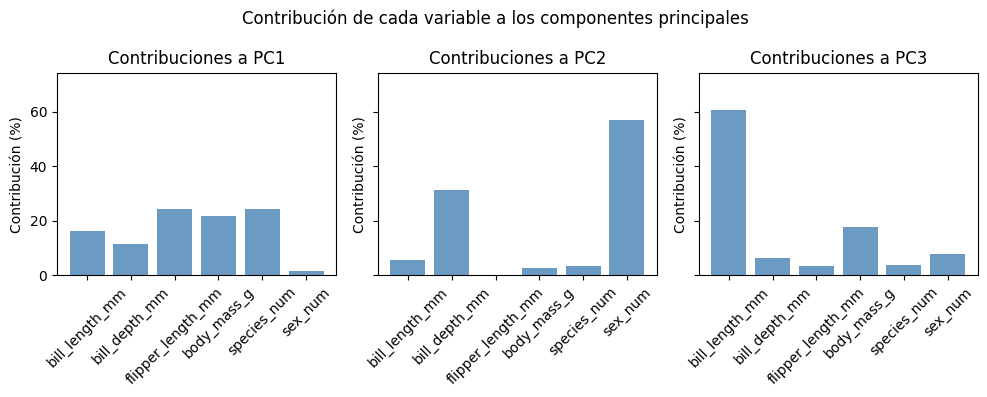

In [32]:
# Seleccionamos cuántos PCs queremos mostrar
pcs_to_plot = ["PC1", "PC2", "PC3"]

fig, axes = plt.subplots(1, len(pcs_to_plot), figsize=(10, 4), sharey=True)

for i, pc in enumerate(pcs_to_plot):
    axes[i].bar(contrib.index, contrib[pc], color="steelblue", alpha=0.8)
    axes[i].set_title(f"Contribuciones a {pc}")
    axes[i].set_ylabel("Contribución (%)")
    axes[i].set_ylim(0, contrib.values.max() * 1.1)  # mismo rango para comparar
    axes[i].tick_params(axis="x", rotation=45)

plt.suptitle("Contribución de cada variable a los componentes principales")
plt.tight_layout()
plt.show()

In [29]:
# %% ------------------------------------------------------------------
# 4c) PUNTAJES DE LOS INDIVIDUOS (también llamados "scores" o "coordenadas de las observaciones")
# ---------------------------------------------------------------------


# Obtener los puntajes (observaciones proyectadas en el nuevo espacio)
X_pca = pca.transform(X_scaled)


# Aquí se muestran las primeras filas de la matriz de datos proyectada en el nuevo sistema
# de ejes creado por el PCA (los componentes principales).
#
# Cada fila representa una observación (individuo, muestra, fila del dataset original).
# Cada columna representa un componente principal (PC1, PC2, ...).
#
# Estos valores son el resultado de aplicar la transformación PCA:
#     X_pca = X_estandarizado × vectores propios (componentes)
#
# Se interpretan como las "coordenadas" de cada individuo en el nuevo espacio reducido,
# y son útiles para:
# - visualizar la dispersión de los datos en 2D o 3D (scatterplot)
# - detectar patrones, agrupamientos, outliers
# - alimentar modelos de machine learning con menos dimensiones


print("Primeras filas de los puntajes (X_pca):")
print(pd.DataFrame(X_pca).head())

Primeras filas de los puntajes (X_pca):
          0         1         2         3         4         5
0 -1.980464  1.033238 -0.479093 -0.691972  0.300467  0.186644
1 -1.774762 -0.810504 -0.118270  0.144007  0.474416 -0.336150
2 -1.822909 -0.702792  0.241503  0.424156 -0.405432 -0.324180
3 -2.268593 -0.449769 -0.181827  0.906155 -0.184810  0.156671
4 -2.036918  1.578139 -0.273007  0.173367 -0.174982  0.402681


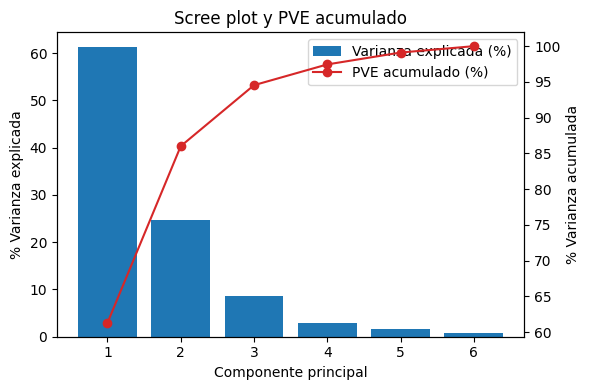

In [30]:
# %% ------------------------------------------------------------------
# 5) Scree Plot + % Varianza Explicada Acumulada (PVE)
# ---------------------------------------------------------------------



explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

fig, ax1 = plt.subplots(figsize=(6, 4))

# --- Scree plot (barras azules) ---
# SCREE PLOT (Gráfico de sedimentación o de codo)
# -------------------------------------------------
# Este gráfico permite visualizar cuánta varianza explica cada componente principal.
# En el eje X se representan los componentes principales (PC1, PC2, ...).
# En el eje Y, la proporción de varianza explicada por cada uno (PVE).
#
# ¿Para qué sirve?
# - Para decidir cuántos componentes retener sin perder demasiada información.
# - Se busca el "punto de codo", es decir, el lugar donde la ganancia de información
#   adicional se vuelve marginal. Desde ahí se justifica cortar.
#
# Esto se conoce como la "regla del codo" y es útil para reducir dimensiones de forma informada.
ax1.bar(
    range(1, len(explained_var) + 1),
    explained_var * 100,
    label="Varianza explicada (%)",
)
ax1.set_xlabel("Componente principal")
ax1.set_ylabel("% Varianza explicada")
ax1.set_title("Scree plot y PVE acumulado")

# --- PVE acumulado (línea roja) ---
# PROPORCIÓN DE VARIANZA EXPLICADA (PVE)
# ---------------------------------------
# Después de aplicar PCA, es importante saber cuánto aporta cada componente principal
# a la explicación de la variabilidad total de los datos originales.
#
# 1. pca.explained_variance_:
#    → contiene la **varianza** que explica cada componente principal (autovalores).
#
# 2. pca.explained_variance_ratio_:
#    → contiene la **proporción** de la varianza total explicada por cada componente,
#       es decir, el porcentaje de información del dataset original que retiene cada PC.
#
#    Por ejemplo, si PC1 tiene un PVE = 0.45, significa que PC1 explica el 45% de la variabilidad total.
#
# Esto es clave para decidir:
# - cuántos componentes conservar
# - cuánta información se pierde si se reducen dimensiones
# - si el PCA es útil para visualizar, resumir o clasificar
#
# Ambos gráficos ayudan a decidir cuántos componentes conservar para alcanzar un umbral deseado
# de varianza retenida, por ejemplo: 80% o 90%.

ax2 = ax1.twinx()
ax2.plot(
    range(1, len(cum_explained_var) + 1),
    cum_explained_var * 100,
    marker="o",
    color="tab:red",
    label="PVE acumulado (%)",
)
ax2.set_ylabel("% Varianza acumulada")

# Leyenda combinada
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper right")
plt.tight_layout()
plt.show()

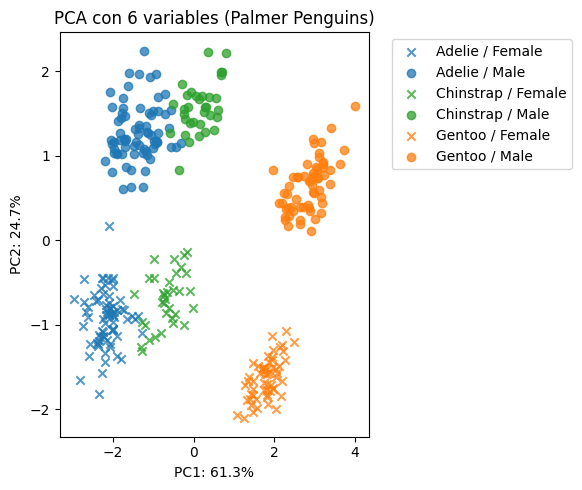

In [31]:
# %% ------------------------------------------------------------------
# 6) APLICACION DE PCA : Scatter PC1 vs PC2  (color = especie, marker = sexo)
# ---------------------------------------------------------------------
# Cada punto es un pingüino proyectado en los ejes PC1, PC2, PC3.
# Colores → especie (Adelie azul, Gentoo naranja, Chinstrap verde).
# Marcadores → sexo (● = macho, ✕ = hembra).
# Interpretación de los ejes
#   PC1 (80 %) concentra casi toda la información de tamaño: masa corporal y longitud de aleta.
#   PC2 (17 %) refleja la morfología del pico (largo vs. profundidad).
#   PC3 (~2 %) añade un pequeño ajuste que permite separar sutilmente machos y hembras dentro de cada especie.
#
# Con sólo 3 de 6 variables transformadas (80 % + 17 % + 2 % ≈ 99 %), conservamos prácticamente toda la variabilidad original.
# Las especies forman clusters definidos, lo que confirma que las medidas morfométricas bastan para identificarlas.
# El eje extra (PC3) es útil si quisiéramos modelar diferencias de sexo sin añadir más dimensiones.

species_palette = {
    "Adelie": "tab:blue",
    "Gentoo": "tab:orange",
    "Chinstrap": "tab:green",
}

markers = {"Male": "o", "Female": "x"}

fig, ax = plt.subplots(figsize=(6, 5))

# Combine los resultados de PCA con el DataFrame original para graficar
scores_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
scores_df['species'] = penguins['species'].values
scores_df['sex'] = penguins['sex'].str.title().values


for spec, group in scores_df.groupby("species"):
    for sex, sub in group.groupby("sex"):
        ax.scatter(
            sub["PC1"],
            sub["PC2"],
            label=f"{spec} / {sex}",
            color=species_palette.get(spec, "grey"),
            marker=markers.get(str(sex).title(), "."),
            alpha=0.75,
        )

ax.set_title("PCA con 6 variables (Palmer Penguins)")
ax.set_xlabel(f"PC1: {explained_var[0] * 100:.1f}%")
ax.set_ylabel(f"PC2: {explained_var[1] * 100:.1f}%")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()